In [124]:
# import matplotlib as mpl
# mpl.use('Agg')
%matplotlib inline


import networkx as nx
import numpy as np
import random
import pandas as pd
import math
from copy import copy
from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from itertools import combinations
from tqdm import tqdm
from joblib import Parallel, delayed

from graph_generator import grid_2d, add_p_and_delta
from simulations import sample_graph_from_infection, simulate_IC, make_input
from plot_utils import plot_snapshot
from core import accuracy_for_nodes, experiment_multiple_rounds, normalize_mu, generate_sufficient_stats
from utils import generalized_jaccard_similarity, infeciton_time2weight
from synthetic_data import (load_data_by_gtype, GRID, KRONECKER_HIER, KRONECKER_PERI, KRONECKER_RAND,
                            PL_TREE, ER, BARABASI)

In [125]:
gtype = GRID
g, times_by_source, source2nodeid_counter = load_data_by_gtype(gtype)
u, v = next(g.edges_iter())
infp = g[u][v]['p']
print('infp = {}'.format(infp))
if gtype == GRID:
    pos = {n: np.array(n) for n in g.nodes()}
else:
    pos = nx.spring_layout(g)

infp = 0.7


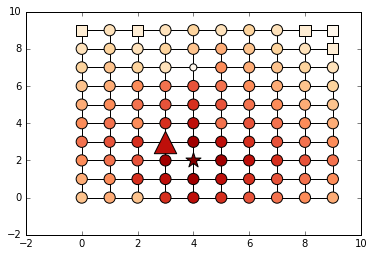

In [126]:
source, obs_nodes, infection_times, tree = make_input(g, infp, 0.05, sampling_method='late_nodes')

node2weight = infeciton_time2weight(infection_times)

plot_snapshot(g, pos, node2weight, 
              query_node=(3, 3),
              source_node=source,
              queried_nodes=obs_nodes, 
              max_node_size=500)

In [127]:
RANDOM = 'random'
MAX_MU = 'max_mu'
MIN_CONSENSUS = 'min_consensus'

WU_FRACTION = 'update_by_matching_fraction'
WU_DIST2MEAN = 'update_by_distance2mean'

In [128]:
from query_strategy import consensus_score

In [150]:
def mwu(g, source, obs_nodes, infection_times,
        times_by_source, 
        source2nodeid_counter,
        epsilon, 
        check_neighbor_threshold=0.1,
        query_selection_method=MAX_MU,
        weight_update_method=WU_DIST2MEAN,  # not in use for now
        debug=False, plot=False,
        inspect_mu=False,
        max_plots=9, 
        max_node_size=500):
    """
    times_by_source: sufficient statistics from each node (precomputed)
    infection_times: observation
    """
    obs_nodes = copy(obs_nodes)
    mu_of_source = []
    ### debugging START    
    if plot:
        if gtype == GRID:
            pos = {n: np.array(n) for n in g.nodes()}
        else:
            pos = nx.spring_layout(g)
            
        ncols = 2
        nrows = math.ceil((max_plots) / ncols)
        width = 12
        height = int(width * nrows / ncols)
        fig, ax = plt.subplots(nrows, ncols,
                               sharex=True, sharey=True,
                               figsize=(width, height))
        node2weight = infeciton_time2weight(infection_times)
        plot_snapshot(g, pos, node2weight, source_node=source,
                      queried_nodes=obs_nodes, ax=ax[0, 0],
                      max_node_size=max_node_size)
        ax[0, 0].set_title('ground truth')
    ### debugging END
        
    node2id = {n: i for i, n in enumerate(g.nodes_iter())}
    mu = {n: 1 for n in g.nodes()}
    mu = normalize_mu(mu)
    mu_of_source.append(mu[source])
            
    query_count = 0
    queried_nodes = set()

    # using the observations
    for q in sorted(obs_nodes, key=lambda n: infection_times[n]):
        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)
        mu = normalize_mu(mu)
        queried_nodes.add(q)

    ### debugging START
    if debug:
        print_nodes_by_mu(g, mu, source)
        
    if plot and max_plots >= 1:
        i, j = 0, 1
                
        plot_snapshot(g, pos, mu, source_node=source, queried_nodes=obs_nodes,
                      ax=ax[i, j], max_node_size=max_node_size)
        ax[i, j].set_title('using observation')
    ### debugging END
        
    max_iter = float('inf')
    iter_i = 0

    all_nodes = set(g.nodes())
    while iter_i < max_iter:
        iter_i += 1
        queryable = list(all_nodes - queried_nodes)
        if len(queryable) == 0:
            if debug:
                print('no more nodes to query')
            break
        if query_selection_method == RANDOM:
            q = random.choice(queryable)
        elif query_selection_method == MAX_MU:
            q = max(all_nodes - queried_nodes, key=lambda n: mu[n])
        elif query_selection_method == MIN_CONSENSUS:
            q = min(queryable,
                    key=lambda cq: consensus_score(cq, times_by_source, mu, node2id,
                                                   source2nodeid_counter))
        else:
            raise ValueEerror('available query methods are {}'.format(RANDOM, MAX_MU, MIN_CONSENSUS))
    
        queried_nodes.add(q)        
        query_count += 1

                ### debugging START
        if plot and iter_i+2 <= max_plots:
            i, j = int((iter_i+1) / ncols), (iter_i+1) % ncols
            plot_snapshot(g, pos, mu, query_node=q, source_node=source,
                          queried_nodes=queried_nodes,
                          ax=ax[i, j],
                          max_node_size=max_node_size)
            ax[i, j].set_title('iter_i={} mu(source)={:.5f} ({})'.format(iter_i,
                                                                   mu[source],
                                                                   check_neighbor_threshold))
        ### debugging END

        
        if debug:
            print('query {}'.format(q))

        # if some node has very large mu
        # query its neighbors
        if not inspect_mu and max(mu.values()) > check_neighbor_threshold:
            s = max(mu, key=mu.__getitem__)
            if s not in queried_nodes:
                query_count += 1
                queried_nodes.add(s)
                
            # update the mu as well
            for q in g.neighbors(s):
                if q not in queried_nodes:
                    outcome = infection_times[q]
                    acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
                    for n, ac in acc.items():
                        mu[n] *= np.power(1-epsilon, 1-ac)
                    mu = normalize_mu(mu)                
            unqueried_nodes = set(filter(lambda u: u not in queried_nodes, g.neighbors(s)))
            query_count += len(unqueried_nodes)
            queried_nodes |= unqueried_nodes
                    
            is_source = np.all(list(map(lambda u: infection_times[s] < infection_times[u],
                                        g.neighbors(s))))
            if is_source:
                if debug:
                    print('**Found source')
                    print('used {} queries'.format(query_count))
                assert source == s
                break
            else:
                # important
                mu[s] = 0

        outcome = infection_times[q]
        acc = accuracy_for_nodes(q, outcome, times_by_source, node2id)
        for n, ac in acc.items():
            mu[n] *= np.power(1-epsilon, 1-ac)

        mu = normalize_mu(mu)    
        
        mu_of_source.append(mu[source])
        if debug:        
            print('iteration: {}'.format(iter_i))
            print_nodes_by_mu(g, mu, source)
    if not plot:
        return query_count, mu_of_source
    else:
        return query_count, mu_of_source, fig

95


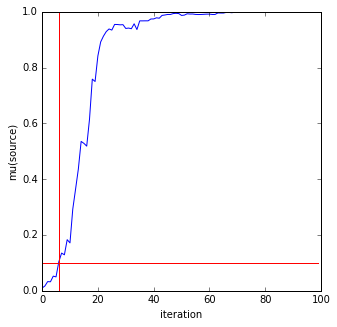

In [130]:
# demo of how mu(source increases)

source, obs_nodes, infection_times, tree = make_input(g, infp=0.7,
                                                      fraction=0.05, sampling_method='late_nodes')
query_count, mu_of_source = mwu(g, source, obs_nodes, infection_times, 
                                times_by_source, source2nodeid_counter,
                                epsilon=0.7,
                                query_selection_method=MAX_MU,
                                check_neighbor_threshold=0.1,
                                inspect_mu=True,
                                debug=False, 
                                plot=False,
                                max_plots=6)
print(query_count)

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(mu_of_source)
ax.plot([0.1]*100, 'r')
ax.set_xlabel('iteration')
ax.set_ylabel('mu(source)')

idx = np.nonzero(np.array(mu_of_source) > 0.1)[0]
if len(idx) > 0:
    half_value = idx[0]
    ax.plot([half_value]*20, np.linspace(0, 1.0, 20), 'r')
fig.savefig('figs/{}_mu_source_vs_iteration.pdf'.format(gtype))

|V|=100, |E|=180
66


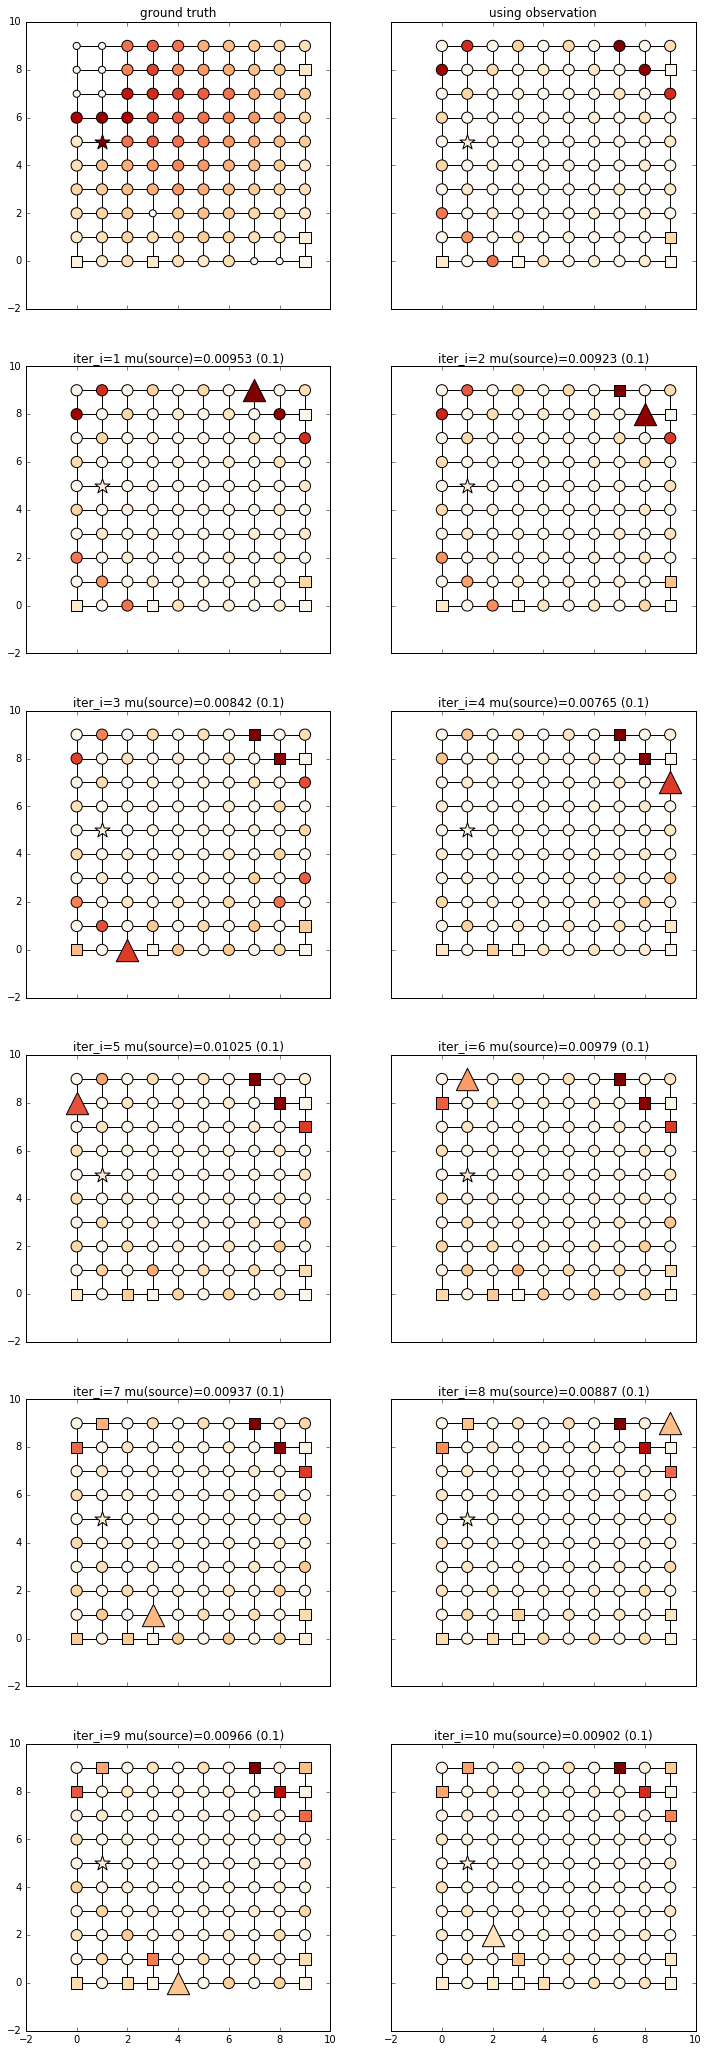

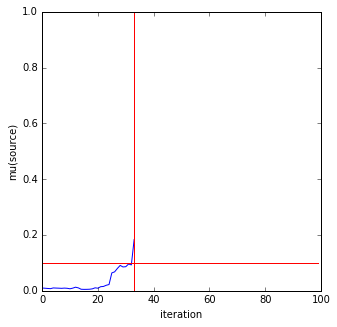

In [151]:
print('|V|={}, |E|={}'.format(g.number_of_nodes(), g.number_of_edges()))
while True:
    source, obs_nodes, infection_times, tree = make_input(
        g, infp=0.7,
        fraction=0.05, sampling_method='late_nodes')    
    query_count, mu_of_source = mwu(g, source, obs_nodes, infection_times, 
                                        times_by_source,
                                        source2nodeid_counter,
                                        epsilon=0.7,
                                        query_selection_method=MAX_MU,
                                        inspect_mu=False,
                                        debug=False, 
                                        plot=False)    
    if query_count > 50:
        break
query_count, mu_of_source, fig = mwu(g, source, obs_nodes, infection_times, 
                                times_by_source,
                                source2nodeid_counter,
                                epsilon=0.7,
                                query_selection_method=MAX_MU,
                                inspect_mu=False,
                                debug=False, 
                                plot=True,
                                max_plots=12)
print(query_count)
fig.savefig('figs/{}_query_process.pdf'.format(gtype))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(mu_of_source)
ax.plot([0.1]*100, 'r')
ax.set_xlabel('iteration')
ax.set_ylabel('mu(source)')

idx = np.nonzero(np.array(mu_of_source) > 0.1)[0]
if len(idx) > 0:
    half_value = idx[0]
    ax.plot([half_value]*20, np.linspace(0, 1.0, 20), 'r')


In [149]:
# dump bad example
if True:
    import os    
    data = {
        'source': source, 'obs_nodes': obs_nodes, 'infection_times': infection_times, 
        'tree': tree,
        'epsilon': 0.7,
        'query_selection_method': MAX_MU
    }
    if not os.path.exists('bad_examples/{}'.format(gtype)):
        os.makedirs('bad_examples/{}'.format(gtype))
    pkl.dump(data, open('bad_examples/{}/1.pkl'.format(gtype), 'wb'))


In [152]:
def experiment_multiple_rounds(rounds, g, 
                               times_by_source, 
                               source2nodeid_counter,
                               infp, fraction, epsilon, sampling_method, 
                               query_selection_method,
                               check_neighbor_threshold,
                               seed=None):
    np.random.seed(seed)
    random.seed(seed)
    results = []
    for i in tqdm(range(rounds)):
        source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
        r = mwu(g, source, obs_nodes, infection_times, 
                times_by_source, source2nodeid_counter,
                epsilon,
               query_selection_method=query_selection_method)
        results.append(r)
    return results

In [153]:
rounds = 500
infp = 0.7
fraction = 0.05
epsilon = 0.8
check_neighbor_threshold = 0.01
sampling_method = 'late_nodes'
params = {
    'infp': infp,
    'fraction': fraction,
    'sampling_method': sampling_method
}

In [154]:
results_by_query_method = {}
for method in [MAX_MU,  RANDOM]:
    result = experiment_multiple_rounds(rounds, g, 
                                        times_by_source, source2nodeid_counter, 
                                        infp, fraction, epsilon, sampling_method,
                                        query_selection_method=method,
                                        check_neighbor_threshold=check_neighbor_threshold,
                                        seed=123456)
    cnts, mu_lists = zip(*result)
    s = pd.Series(cnts)
    results_by_query_method[method] = s.describe().to_dict()


100%|██████████| 500/500 [00:09<00:00, 54.95it/s]


In [155]:
from baselines import baseline_dog_tracker

baseline_cnts = []
for i in range(rounds):
    source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    baseline_cnts.append(c)
results_by_query_method['dog'] = pd.Series(baseline_cnts).describe().to_dict()
result = pd.DataFrame.from_dict(results_by_query_method)    

In [156]:
print('number of nodes: {}'.format(g.number_of_nodes()))

number of nodes: 100


In [157]:
result

,dog,max_mu,random
25%,21.000000,7.00000,9.000000
50%,24.000000,9.00000,12.000000
75%,26.000000,14.00000,19.000000
count,500.000000,500.00000,500.000000
max,43.000000,99.00000,99.000000
mean,23.542000,12.02600,15.642000
min,2.000000,3.00000,3.000000
std,4.917785,10.48605,12.191107


In [158]:
d = 'outputs/{}'.format(gtype)
if not os.path.exists(d):
    os.makedirs(d)
result.to_pickle('{}/performance_comparison.pkl'.format(d))

In [28]:
print(result.to_latex(float_format='%.2f'))

\begin{tabular}{lrrr}
\toprule
{} &    dog &  max\_mu &  random \\
\midrule
25\%   &  10.00 &   11.00 &   12.00 \\
50\%   &  13.00 &   16.00 &   16.00 \\
75\%   &  14.00 &   19.00 &   19.00 \\
count & 500.00 &  500.00 &  500.00 \\
max   &  18.00 &   19.00 &   19.00 \\
mean  &  12.09 &   14.28 &   14.66 \\
min   &   5.00 &    3.00 &    4.00 \\
std   &   2.81 &    4.71 &    4.21 \\
\bottomrule
\end{tabular}



In [ ]:
if False:
    rounds = 500
    infp = 0.7
    fraction = 0.02
    epsilon = 0.8
    sampling_method = 'late_nodes'
    check_neighbor_threshold = 0.1
    
    # calling it outside 
    result = experiment_multiple_rounds(rounds, g, 
                                        times_by_source, source2nodeid_counter, 
                                        infp, fraction, epsilon, sampling_method,
                                        query_selection_method='max_mu',
                                        check_neighbor_threshold=check_neighbor_threshold)
    cnts, _ = zip(*result)
    print(np.mean(cnts))  # 10.252
    print(np.median(cnts)) # 8.0

    # calling it using parallel
    epsilons = [epsilon]
    results = Parallel(n_jobs=-1)(
        delayed(experiment_multiple_rounds)(rounds, g, 
                                            times_by_source, source2nodeid_counter, 
                                            infp, fraction, epsilon, sampling_method,
                                            query_selection_method='max_mu',
                                            check_neighbor_threshold=check_neighbor_threshold)
        for eps in epsilons)

    cnts, _ = zip(*results[0])
    print(np.mean(cnts))  # 14.208
    print(np.median(cnts))  # 11.0    

In [ ]:
epsilons = np.linspace(0.2, 0.9, 8)
# epsilons = [0.8]
results = []

for eps in tqdm(epsilons):
    result = experiment_multiple_rounds(rounds, g, 
                                            times_by_source, source2nodeid_counter, 
                                            infp, fraction, epsilon, sampling_method,
                                            query_selection_method='max_mu',
                                            check_neighbor_threshold=check_neighbor_threshold)
    results.append(result)    

In [ ]:
list_cnts = [list(zip(*result))[0] for result in results]
means = list(map(np.mean, list_cnts))
medians = list(map(np.median, list_cnts))
df = pd.DataFrame.from_dict({'eps': epsilons,
                             'mean': means, 
                             'median': medians})
df    

In [ ]:
from baselines import baseline_dog_tracker

baseline_cnts = []
for i in range(rounds):
    source, obs_nodes, infection_times, tree = make_input(g, infp, fraction, sampling_method=sampling_method)
    c = baseline_dog_tracker(g, obs_nodes, infection_times)
    baseline_cnts.append(c)

In [ ]:
pd.Series(baseline_cnts).describe().to_dict()

In [ ]:
print('mean', np.mean(baseline_cnts))
print('median', np.median(baseline_cnts))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax0, ax1 = axes
df.plot(x='eps', y=['mean'], ax=ax0)
ax0.plot([np.mean(baseline_cnts)] * len(epsilons))
ax0.legend(['multiplicative (max mu strategy)', 'baseline'])
ax0.set_ylim(0, 100)
ax0.set_title('mean')
ax0.set_ylabel('query count')

df.plot(x='eps', y=['median'], ax=axes[1])
ax1.plot([np.median(baseline_cnts)] * len(epsilons))
ax1.legend(['multiplicative (max mu strategy)', 'baseline'])
ax1.set_ylim(0, 100)
ax1.set_title('median')
ax1.set_ylabel('query count')

In [ ]:
fig.savefig('figs/grid-{}-{}.png'.format(sampling_method, fraction))

In [ ]:
df.to_pickle('outputs/mwu-{}-{}.pkl'.format(sampling_method, fraction))
import pickle
pd.Series(baseline_cnts).to_pickle('outputs/dog-{}-{}.pkl'.format(sampling_method, fraction))

In [ ]:
# summarize result
eps = 0.8
sampling_methods = ['uniform', 'late_nodes']
fraction = 0.02
for s in sampling_methods:
    s1 = pd.read_pickle('outputs/mwu-{}-{}.pkl'.format(s, fraction))
    s2_cnts = pd.read_pickle('outputs/dog-{}-{}.pkl'.format(s, fraction))
    print('method', s)
    print('mean', s1[s1['eps'] == 0.8].iloc[0]['mean'], np.mean(s2_cnts))
    print('median', s1[s1['eps'] == 0.8].iloc[0]['median'], np.median(s2_cnts))    
    print()